In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

In [2]:
# Well howdy there friend.
# This script was adapted to help you do the following with your CSV file:
#
# 1) Compute AVW for point data from the CSV
# 2) Determine the QWIP score for all the data points
# 3) Make some useful plots to help you assess radiometric quality
#
# Make sure your CSV file is in the current directory.
# The CSV has columns: Latitude, Longitude, TSS, Rrs_400, ..., Rrs_800
fname = 'GLORIA_plus_lab_SAB_400nm_800nm_all_python.csv'

# Reading in the data
df = pd.read_csv(fname)
lat = df['Latitude'].values
lon = df['Longitude'].values
rrs_cols = [col for col in df.columns if col.startswith('Rrs_')]
wavelengths = np.array([int(col.split('_')[1]) for col in rrs_cols])
# Assume wavelengths are sorted; if not, sort them
sort_idx = np.argsort(wavelengths)
wavelengths = wavelengths[sort_idx]
rrs_cols = np.array(rrs_cols)[sort_idx]
Rrs = df[rrs_cols].values  # shape (num_points, num_waves)
num_points = len(lat)
# Here we manually define the visible range of wavelengths.
# Note: AVW doesn't use the UV/NIR in the calculation.
min_wave = 400
max_wave = 700
min_index = np.argmin(np.abs(wavelengths - min_wave))
max_index = np.argmin(np.abs(wavelengths - max_wave))
wave_vis = wavelengths[min_index:max_index + 1]
RRS_vis = Rrs[:, min_index:max_index + 1]  # (num_points, vis_waves)

In [4]:
# This is inefficient, but the QWIP is calibrated against 1-nm data,
# so we interpolate to 1-nm sampling with cubic spline interpolation.
# While looping through, we calculate the AVW array.
AVW = np.zeros(num_points)
wave_1nm = np.arange(400, 701)
for i in range(num_points):
    interim_arr = RRS_vis[i, :]
    interim_arr[np.isnan(interim_arr)] = 0
    f = interp1d(wave_vis, interim_arr, kind='cubic')
    RRS_1nm = f(wave_1nm)
    # Avoid division by zero if all RRS_1nm are zero
    denom = np.sum(RRS_1nm / wave_1nm)
    if denom == 0:
        AVW[i] = np.nan
    else:
        AVW[i] = np.sum(RRS_1nm) / denom

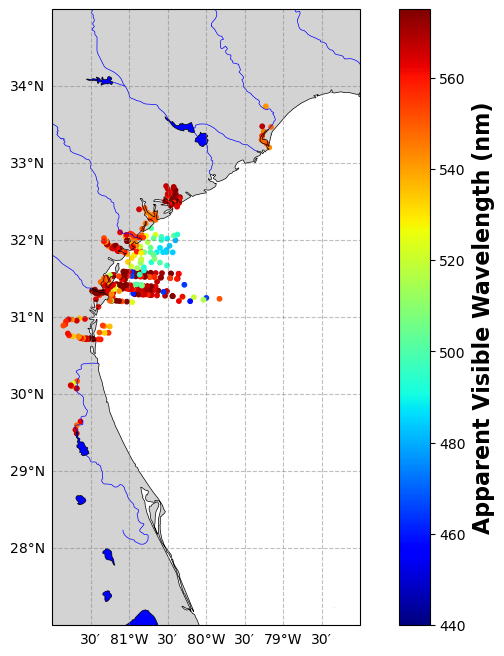

In [38]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt

# Define South Atlantic Bight extent (lon: -82 to -78, lat: 27 to 35)
sab_extent = [-82, -78, 27, 35]

# Plotting AVW map as scatter plot with enhancements for SAB area
fig1, ax1 = plt.subplots(figsize=(10, 8), subplot_kw={'projection': ccrs.PlateCarree()})
ax1.set_extent(sab_extent, crs=ccrs.PlateCarree())
sc1 = ax1.scatter(lon, lat, c=AVW, cmap='jet', vmin=440, vmax=575, s=10, transform=ccrs.PlateCarree())
ax1.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax1.add_feature(cfeature.LAND, facecolor='lightgray')
ax1.add_feature(cfeature.LAKES.with_scale('10m'), facecolor='blue', edgecolor='black', linewidth=0.5)
ax1.add_feature(cfeature.RIVERS.with_scale('10m'), edgecolor='blue', linewidth=0.5)
gl = ax1.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
ax1.set_xlabel('Longitude', fontsize=18, fontweight='bold')
ax1.set_ylabel('Latitude', fontsize=18, fontweight='bold')
cbar = plt.colorbar(sc1)
cbar.set_label('Apparent Visible Wavelength (nm)', fontsize=16, fontweight='bold')
plt.show()

In [8]:
# Now we calculate the Quality Control Index (QCI)
# (Rrs_665 - Rrs_490) / (Rrs_665 + Rrs_490)
# Finding the closest wavelength match automatically
# and also computing the polynomial fit
index_490 = np.argmin(np.abs(wave_vis - 490))
index_665 = np.argmin(np.abs(wave_vis - 665))
QCI = (RRS_vis[:, index_665] - RRS_vis[:, index_490]) / (RRS_vis[:, index_665] + RRS_vis[:, index_490])
avw_poly = np.arange(400, 631)
p = np.array([-8.399885e-09, 1.715532e-05, -1.301670e-02, 4.357838, -5.449532e02])
fit1 = np.polyval(p, avw_poly)


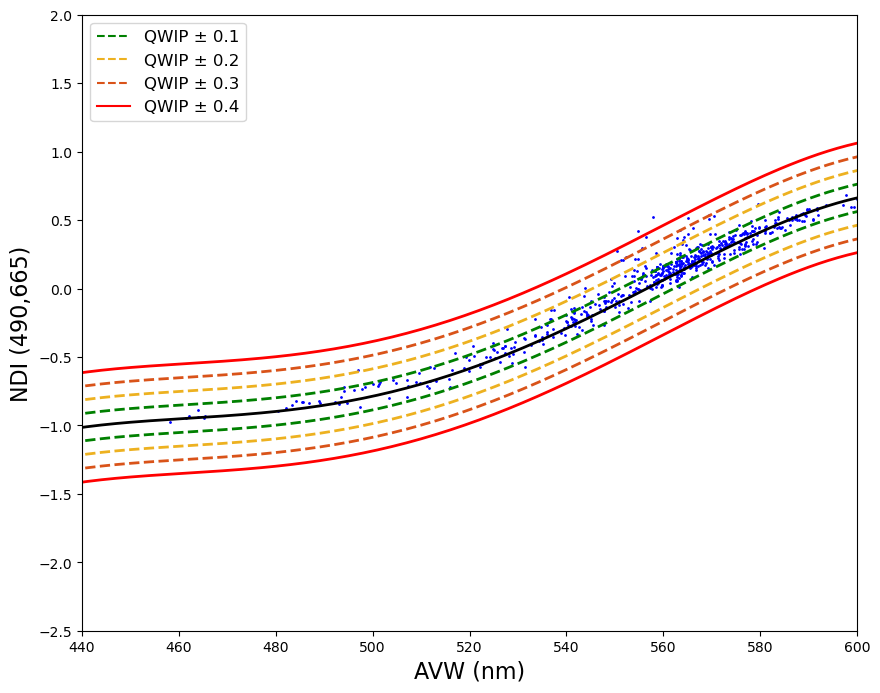

In [21]:
# Generating an array of the "predicted" QCI based on the AVW values.
# We then subtract this from the actual QCI to get QWIP score.
QCI_pred = np.polyval(p, AVW)
QWIP_score = QCI_pred - QCI
abs_QWIP_score = np.abs(QWIP_score)
# Generate figure to show QCI index relative to AVW
fit1a = fit1 + 0.1
fit1b = fit1 - 0.1
fit2a = fit1 + 0.2
fit2b = fit1 - 0.2
fit3a = fit1 + 0.3
fit3b = fit1 - 0.3
fit4a = fit1 + 0.4
fit4b = fit1 - 0.4
fig2, ax2 = plt.subplots(figsize=(10, 8))
ax2.plot(AVW, QCI, 'ob', markersize=1)
ax2.plot(avw_poly, fit1, '-k', linewidth=2)
ax2.plot(avw_poly, fit1a, '--g', linewidth=2)
ax2.plot(avw_poly, fit1b, '--g', linewidth=2)
ax2.plot(avw_poly, fit2a, '--', linewidth=2, color=[0.9290, 0.6940, 0.1250])
ax2.plot(avw_poly, fit2b, '--', linewidth=2, color=[0.9290, 0.6940, 0.1250])
ax2.plot(avw_poly, fit3a, '--', linewidth=2, color=[0.8500, 0.3250, 0.0980])
ax2.plot(avw_poly, fit3b, '--', linewidth=2, color=[0.8500, 0.3250, 0.0980])
ax2.plot(avw_poly, fit4a, '-r', linewidth=2)
ax2.plot(avw_poly, fit4b, '-r', linewidth=2)
ax2.set_xlabel('AVW (nm)', fontsize=16)
ax2.set_ylabel(f'NDI ({wave_vis[index_490]},{wave_vis[index_665]})', fontsize=16)
ax2.set_ylim([-2.5, 2])
ax2.set_xlim([440, 600])

# Legend hacks
LH = [
    ax2.plot(np.nan, np.nan, '--g')[0],
    ax2.plot(np.nan, np.nan, '--', color=[0.9290, 0.6940, 0.1250])[0],
    ax2.plot(np.nan, np.nan, '--', color=[0.8500, 0.3250, 0.0980])[0],
    ax2.plot(np.nan, np.nan, '-r')[0]
]
L = ['QWIP ± 0.1', 'QWIP ± 0.2', 'QWIP ± 0.3', 'QWIP ± 0.4']
ax2.legend(LH, L, loc='upper left', fontsize=12)
plt.show()

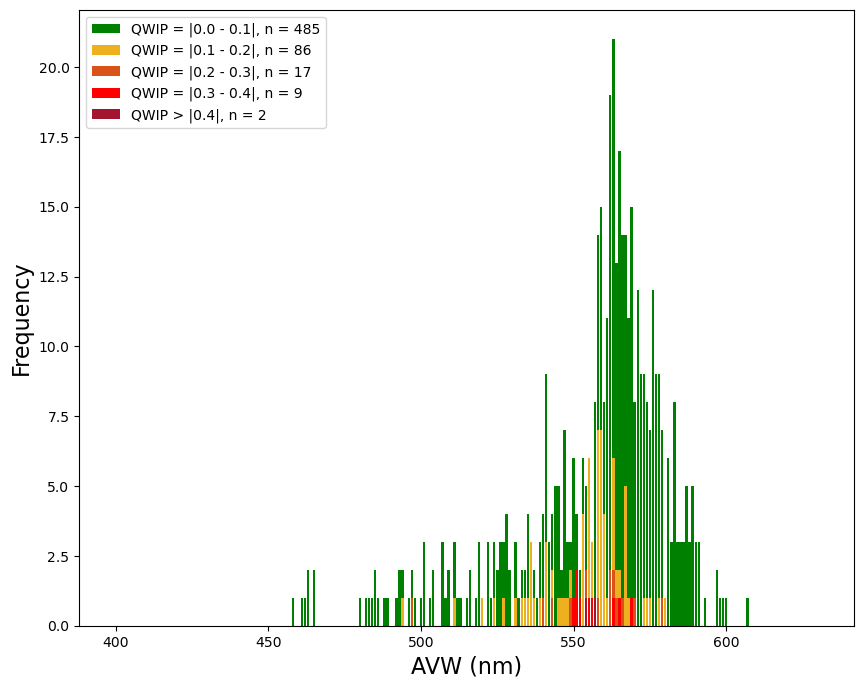

In [26]:
# # Fun little hint here, if you want to plot a specific spectrum,
# # you can select a point from the plot above and find its index.
# # For example:
# # Suppose you have the AVW and QCI values of a point:
# # idx = np.where((AVW == selected_avw) & (QCI == selected_qci))[0]
# # if len(idx) > 0:
# #     idx = idx[0]
# #     RRS_plot = RRS_vis[idx, :]
# #     plt.plot(wave_vis, RRS_plot, '-b', linewidth=2)
# #     plt.show()

# # Now, making incremental bins of QWIP scores (0-0.1, 0.1-0.2, etc.)
# # and histograms as a function of AVW.

hist_bin1 = np.zeros(231)
hist_bin2 = np.zeros(231)
hist_bin3 = np.zeros(231)
hist_bin4 = np.zeros(231)
hist_bin5 = np.zeros(231)

for i in range(400, 631):
    j = i + 0.9999
    k = i - 400  # 0-based index: for i=400, k=0; for i=630, k=230
    flag = (AVW > i) & (AVW < j)
    
    flag2 = (QCI >= fit1[k] - 0.1) & (QCI <= fit1[k] + 0.1)
    flag3 = flag & flag2
    hist_bin1[k] = np.sum(flag3)
    
    flag2 = ((QCI >= fit1[k] - 0.2) & (QCI < fit1[k] - 0.1)) | ((QCI <= fit1[k] + 0.2) & (QCI > fit1[k] + 0.1))
    flag3 = flag & flag2
    hist_bin2[k] = np.sum(flag3)
    
    flag2 = ((QCI >= fit1[k] - 0.3) & (QCI < fit1[k] - 0.2)) | ((QCI <= fit1[k] + 0.3) & (QCI > fit1[k] + 0.2))
    flag3 = flag & flag2
    hist_bin3[k] = np.sum(flag3)
    
    flag2 = ((QCI >= fit1[k] - 0.4) & (QCI < fit1[k] - 0.3)) | ((QCI <= fit1[k] + 0.4) & (QCI > fit1[k] + 0.3))
    flag3 = flag & flag2
    hist_bin4[k] = np.sum(flag3)
    
    flag2 = (QCI < fit1[k] - 0.4) | (QCI > fit1[k] + 0.4)
    flag3 = flag & flag2
    hist_bin5[k] = np.sum(flag3)

fig3, ax3 = plt.subplots(figsize=(10, 8))
ax3.bar(range(400, 631), hist_bin1, color='g', label=f'QWIP = |0.0 - 0.1|, n = {int(np.sum(hist_bin1))}')
ax3.bar(range(400, 631), hist_bin2, color=[0.9290, 0.6940, 0.1250], label=f'QWIP = |0.1 - 0.2|, n = {int(np.sum(hist_bin2))}')
ax3.bar(range(400, 631), hist_bin3, color=[0.8500, 0.3250, 0.0980], label=f'QWIP = |0.2 - 0.3|, n = {int(np.sum(hist_bin3))}')
ax3.bar(range(400, 631), hist_bin4, color='r', label=f'QWIP = |0.3 - 0.4|, n = {int(np.sum(hist_bin4))}')
ax3.bar(range(400, 631), hist_bin5, color=[0.6350, 0.0780, 0.1840], label=f'QWIP > |0.4|, n = {int(np.sum(hist_bin5))}')
ax3.set_xlabel('AVW (nm)', fontsize=16)
ax3.set_ylabel('Frequency', fontsize=16)
ax3.legend(loc='upper left')
plt.show()

In [37]:
# !pip install cartopy

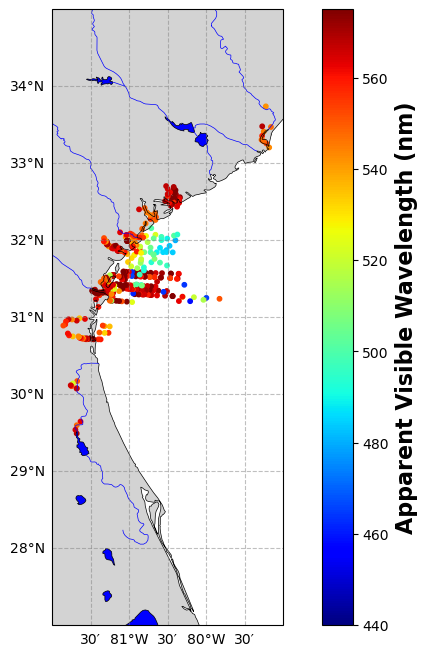

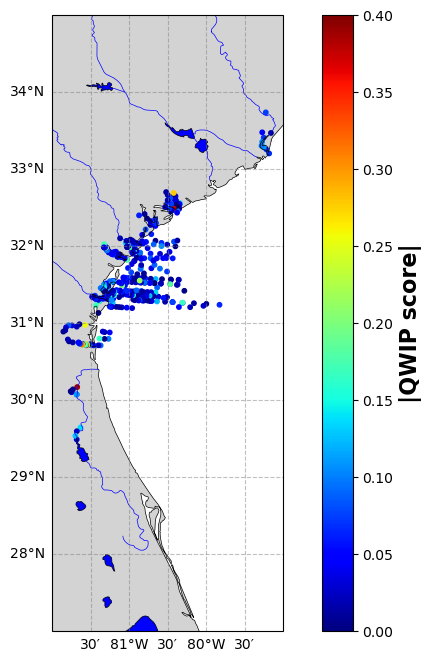

In [36]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
import matplotlib.pyplot as plt

# Define South Atlantic Bight extent (approx. lon: -81 to -75, lat: 27 to 35)
sab_extent = [-82, -79, 27, 35]

# Plotting AVW map as scatter plot with enhancements
# Assuming lat, lon, AVW are defined from earlier code
fig1, ax1 = plt.subplots(figsize=(10, 8), subplot_kw={'projection': ccrs.PlateCarree()})
ax1.set_extent(sab_extent, crs=ccrs.PlateCarree())
sc1 = ax1.scatter(lon, lat, c=AVW, cmap='jet', vmin=440, vmax=575, s=10, transform=ccrs.PlateCarree())
ax1.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax1.add_feature(cfeature.LAND, facecolor='lightgray')
ax1.add_feature(cfeature.LAKES.with_scale('10m'), facecolor='blue', edgecolor='black', linewidth=0.5)
ax1.add_feature(cfeature.RIVERS.with_scale('10m'), edgecolor='blue', linewidth=0.5)
gl = ax1.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
ax1.set_xlabel('Longitude', fontsize=18, fontweight='bold')
ax1.set_ylabel('Latitude', fontsize=18, fontweight='bold')
cbar = plt.colorbar(sc1)
cbar.set_label('Apparent Visible Wavelength (nm)', fontsize=16, fontweight='bold')
plt.show()

# Plotting the absolute QWIP score as scatter plot with enhancements
fig4, ax4 = plt.subplots(figsize=(10, 8), subplot_kw={'projection': ccrs.PlateCarree()})
ax4.set_extent(sab_extent, crs=ccrs.PlateCarree())
sc4 = ax4.scatter(lon, lat, c=abs_QWIP_score, cmap='jet', vmin=0, vmax=0.4, s=10, transform=ccrs.PlateCarree())
ax4.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax4.add_feature(cfeature.LAND, facecolor='lightgray')
ax4.add_feature(cfeature.LAKES.with_scale('10m'), facecolor='blue', edgecolor='black', linewidth=0.5)
ax4.add_feature(cfeature.RIVERS.with_scale('10m'), edgecolor='blue', linewidth=0.5)
gl = ax4.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
ax4.set_xlabel('Longitude', fontsize=18, fontweight='bold')
ax4.set_ylabel('Latitude', fontsize=18, fontweight='bold')
cbar = plt.colorbar(sc4)
cbar.set_label('|QWIP score|', fontsize=16, fontweight='bold')
plt.show()



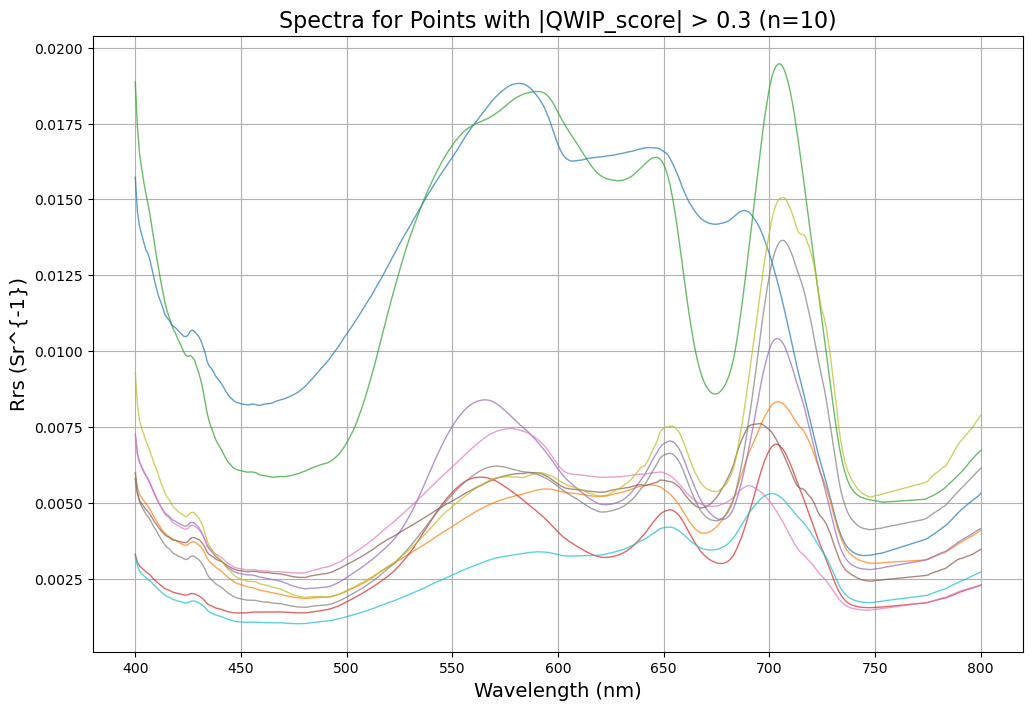

Cleaned CSV saved as: cleaned_GLORIA_plus_lab_SAB_400nm_800nm_all_python.csv


In [39]:
## Cleaned the data which have QWIP +- 0.3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Assuming the following variables are already defined from previous code:
# - df: the original DataFrame
# - wavelengths: array of wavelengths from 400 to 800
# - Rrs: 2D array of Rrs values (num_points, num_waves)
# - abs_QWIP_score: array of absolute QWIP scores

# Find indices where |QWIP_score| > 0.3
bad_indices = np.where(abs_QWIP_score > 0.3)[0]

# Plot the spectra for these points
if len(bad_indices) > 0:
    fig, ax = plt.subplots(figsize=(12, 8))
    for idx in bad_indices:
        ax.plot(wavelengths, Rrs[idx, :], linewidth=1, alpha=0.7)
    ax.set_xlabel('Wavelength (nm)', fontsize=14)
    ax.set_ylabel('Rrs (Sr^{-1})', fontsize=14)
    ax.set_title(f'Spectra for Points with |QWIP_score| > 0.3 (n={len(bad_indices)})', fontsize=16)
    ax.grid(True)
    plt.show()
else:
    print("No points with |QWIP_score| > 0.3 found.")

# Remove these rows from the DataFrame
cleaned_df = df.drop(bad_indices).reset_index(drop=True)

# Save the cleaned DataFrame to a new CSV file
cleaned_filename = 'cleaned_GLORIA_plus_lab_SAB_400nm_800nm_all_python.csv'
cleaned_df.to_csv(cleaned_filename, index=False)
print(f"Cleaned CSV saved as: {cleaned_filename}")

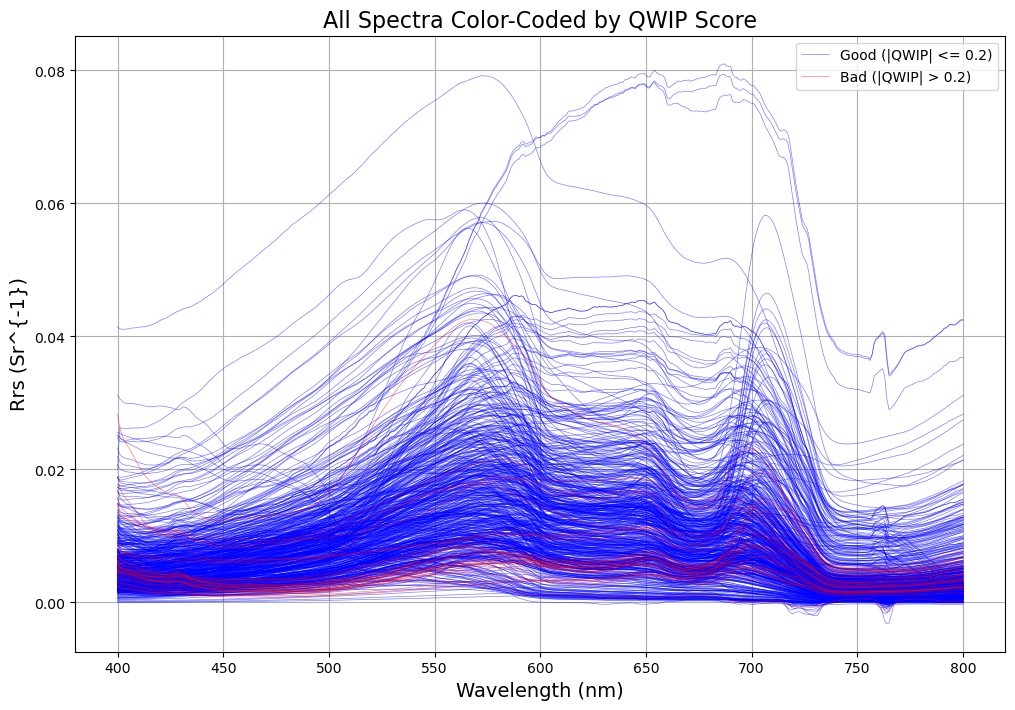

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Assuming the following variables are already defined from previous code:
# - wavelengths: array of wavelengths from 400 to 800 (full range)
# - Rrs: 2D array of Rrs values (num_points, num_waves_full), where num_waves_full covers 400-800
# - abs_QWIP_score: array of absolute QWIP scores (num_points,)

# Plot all spectra, color-coded by |QWIP_score| <= 0.3 (good, blue) or > 0.3 (bad, red)
fig, ax = plt.subplots(figsize=(12, 8))

# Good spectra (|QWIP| <= 0.3)
good_indices = np.where(abs_QWIP_score <= 0.2)[0]
for idx in good_indices:
    ax.plot(wavelengths, Rrs[idx, :], color='blue', linewidth=0.5, alpha=0.5, label='Good (|QWIP| <= 0.2)' if idx == good_indices[0] else None)

# Bad spectra (|QWIP| > 0.3)
bad_indices = np.where(abs_QWIP_score > 0.2)[0]
for idx in bad_indices:
    ax.plot(wavelengths, Rrs[idx, :], color='red', linewidth=0.5, alpha=0.5, label='Bad (|QWIP| > 0.2)' if idx == bad_indices[0] else None)

ax.set_xlabel('Wavelength (nm)', fontsize=14)
ax.set_ylabel('Rrs (Sr^{-1})', fontsize=14)
ax.set_title('All Spectra Color-Coded by QWIP Score', fontsize=16)
ax.grid(True)
ax.legend()
plt.show()